In [1]:
import pandas as pd
import numpy as np
import yaml
import os
import cartopy.crs as ccrs

## Real vs Estimated

In [2]:
from traffic.data.samples import fuelflow_a320

In [3]:
df_sample = fuelflow_a320.data[['timestamp', 'altitude', 'groundspeed', 'CAS', 'vertical_acceleration', 'weight', 'fuelflow']].copy()

In [4]:
df_sample = fuelflow_a320.data[['timestamp', 'altitude', 'CAS', 'fuelflow']].copy()

In [5]:
# change the fuelflow unit from kg/h to kg/s
df_sample['fuelflow_1'] = df_sample['fuelflow'].apply(lambda x: x/3600)

# add vertical_rate
df_sample['vertical_rate'] = df_sample['altitude'].diff().fillna(0) * 60

df_sample.drop('fuelflow', axis=1, inplace=True)

In [6]:
from traffic.core import Flight

ff = Flight(df_sample)

df_new = ff.fuelflow(initial_mass=None ,typecode='A320').data

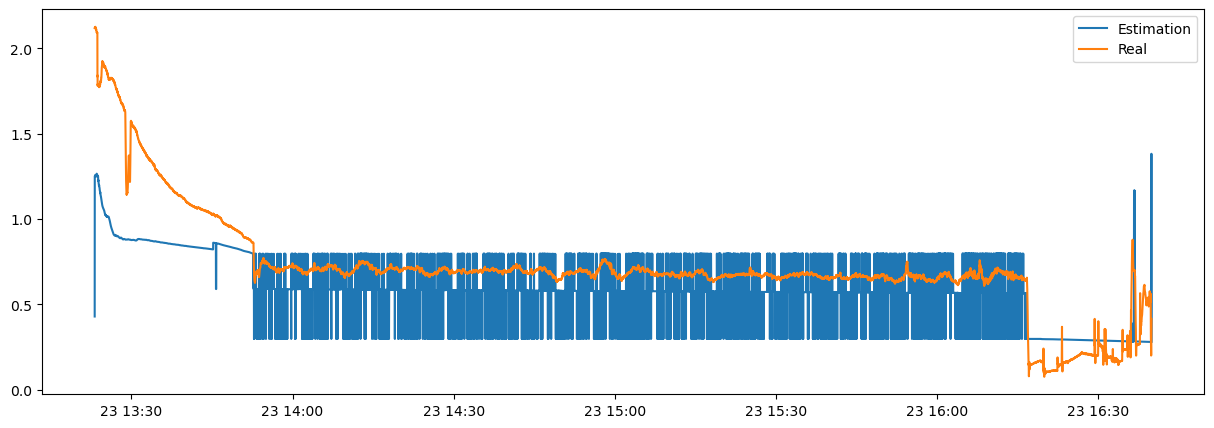

In [7]:
import matplotlib.pyplot as plt

# plot fuelflow and fuelflow_1 vs timestamp
plt.figure(figsize=(15, 5))
plt.plot(df_new['timestamp'], df_new['fuelflow'], label='Estimation')
plt.plot(df_new['timestamp'], df_new['fuelflow_1'], label='Real')
plt.legend()
plt.show()

In [8]:
# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)

"""
# Package for downloading opensky data 
from src.backend import opensky_query
# Utilities package
from src.backend import utils
# Package used to compress state vectors data
from src.backend import compressors
# Package to generate plot images
from src.frontend import plotter
"""

data_directory = '../data/flight/KJFK_KLAX/'
# From here we load the config file
with open(f'{root_path}/config/config_template.yml', 'r', encoding='utf8') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)



state_vectors_file = [f'{data_directory}/state_vectors/{f}' \
                      for f in os.listdir(f'{data_directory}/state_vectors/') if f.endswith('.csv')]

In [9]:
import datetime as dt

for file in state_vectors_file:
    df = pd.read_csv(file)
    df['time'] = df['time'].apply(lambda x: dt.datetime.fromtimestamp(x))
    #save the file in flight/KJFK_KLAX_mod folder
    df.to_csv(f'{data_directory}/state_vectors_mod/{os.path.basename(file)}', index=False)

In [10]:
state_vectors_mod_file = [f'{data_directory}/state_vectors_mod/{f}' \
                          for f in os.listdir(f'{data_directory}/state_vectors_mod/') if f.endswith('.csv')]

In [11]:
flight_data = pd.read_csv('../data/flight/KJFK_KLAX/KJFK_KLAX_2023-01-01_2023-02-01.csv')

# Convert the firstseen column to datetime
flight_data['firstseen'] = flight_data['firstseen'].apply(lambda x: dt.datetime.fromtimestamp(x))


In [12]:
for file in state_vectors_mod_file:
    df = pd.read_csv(file, parse_dates=['time'])

    df['altitude'] = df['baroaltitude']
    df['TAS'] = df['velocity']

    # add vertical_rate
    df['vertical_rate'] = df['altitude'].diff().fillna(0) * 3

    # add icao24 from flight_data
    
    date = df.loc[0, 'time'].date()
    time = df.loc[0, 'time'].time()
    f_data_date = flight_data[flight_data['firstseen'].dt.date == date].copy()

    # Calculate the absolute difference between the 'time' column and the target time
    f_data_date['time_diff'] = abs(f_data_date['firstseen'] - df.loc[0, 'time'])

    # Filter rows where the difference is less than 100 minutes
    close_times = f_data_date[f_data_date['time_diff'] < pd.Timedelta(minutes=100)].copy()
    close_times.sort_values('time_diff', inplace=True)

    if not close_times.empty:
        icoa = close_times['icao24'].values[0]
        df['icao24'] = icoa

    # rename time to timestamp
    df.rename(columns={'time': 'timestamp'}, inplace=True)

    # remove unnecessary columns: velocity, baroaltitude, geoaltitude, heading, lat, lon
    #df.drop(columns=['velocity', 'baroaltitude', 'geoaltitude', 'heading', 'lat', 'lon'], inplace=True)
    
    #save the file in flight/KJFK_KLAX_mod folder
    df.to_csv(f'{data_directory}/state_vectors_mod2/{os.path.basename(file)}', index=False)

In [13]:
state_vectors_mod2_file = [f'{data_directory}/state_vectors_mod2/{f}' \
                          for f in os.listdir(f'{data_directory}/state_vectors_mod2/') if f.endswith('.csv')]

In [14]:
num = 0
list_not_id = []
for file in state_vectors_mod2_file:
    df = pd.read_csv(file, parse_dates=['timestamp'])
    if 'icao24' not in df.columns:
        list_not_id.append(file)
        num += 1
print(num)

2


In [15]:
# put all the flights in a list
flights = [pd.read_csv(file, parse_dates=['timestamp']) for file in state_vectors_mod2_file if file not in list_not_id]


In [16]:
# finding fuel consumption for each flight
from traffic.core import Flight

# initialize a list for fuel consumption
flights_fuel= []

for flight in flights:
    # calculate the fuel consumption
    ff = Flight(flight)
    flights_fuel.append(ff.fuelflow().data)
    

In [17]:
num_1 = 0
list_no_fuel = []
for flight in flights_fuel:
    if 'fuelflow' not in flight.columns:
        list_no_fuel.append(flight)
        num_1 += 1
print(num_1)

25


In [18]:
# remove the flights that don't have fuel consumption from flights_fuel
flights_w_fuel = [flight for flight in flights_fuel if 'fuelflow' in flight.columns]

In [19]:
# calculate fuel consumption for each flight
fuel_consumption = []

for flight in flights_w_fuel:
    fuel_consumption.append((flight['fuelflow']*20).sum()) # multiply by 20 seconds because the time interval is 20 seconds

/var/folders/t6/rx8j2pqs09l9rckj9vd_4zt80000gn/T/ipykernel_25738/788533153.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuel Consumption (kg)', shrink=0.4)


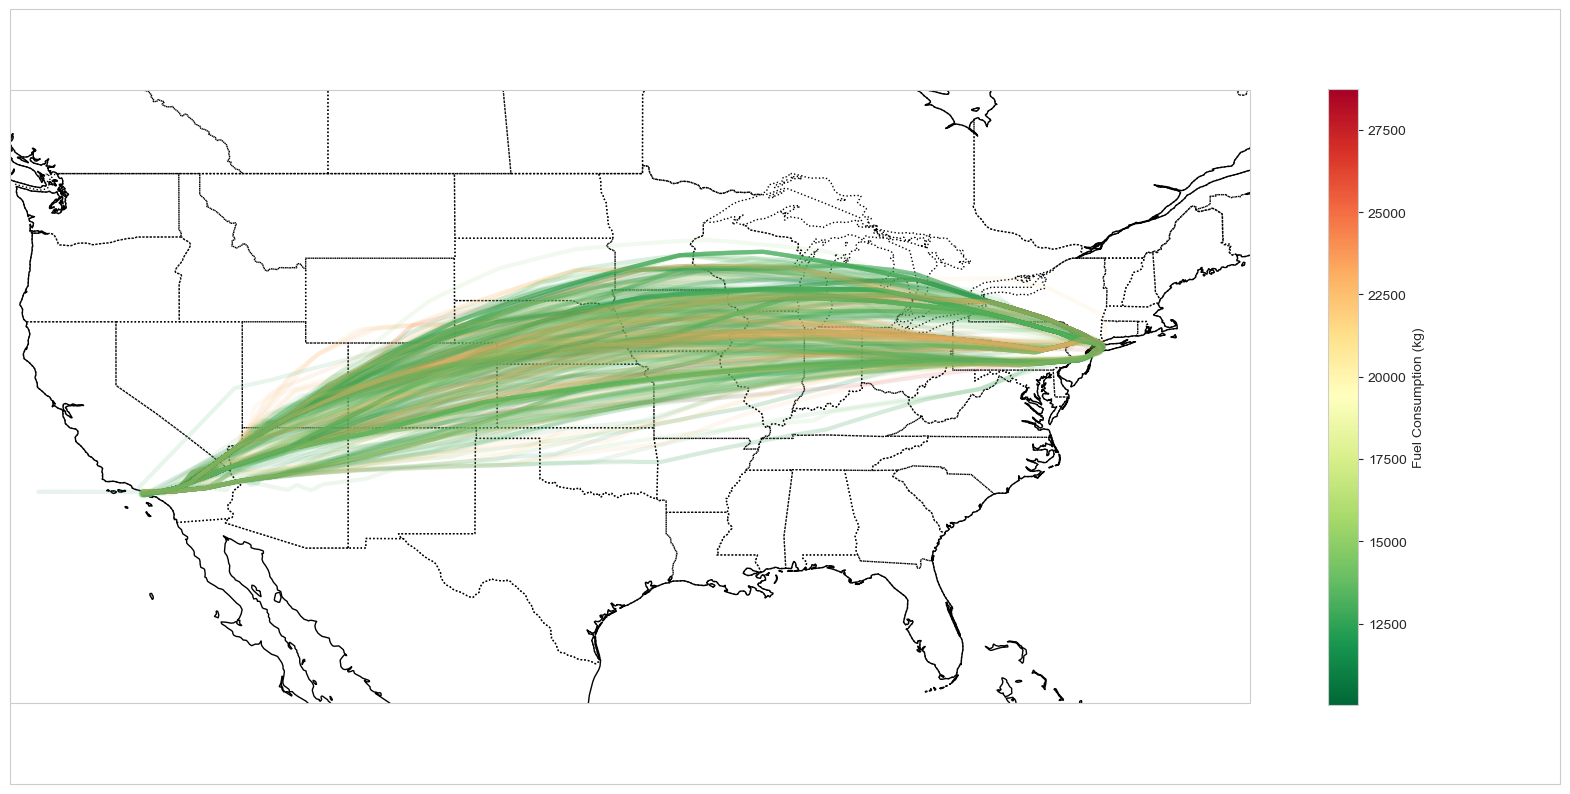

In [20]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.feature as cfeature


# Use a style
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=[20, 20])

# Create a GeoAxes in the PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and states
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.set_extent([-125, -66.5, 24, 49.5])


# Create a colormap
#cmap = plt.get_cmap('Purples')

# Create a colormap
cmap = sns.color_palette("RdYlGn_r", as_cmap=True)
norm = mcolors.Normalize(vmin=np.min(fuel_consumption), vmax=np.max(fuel_consumption))

for flight in flights_w_fuel:
    color = cmap(norm((flight['fuelflow']*20).sum()))
    ax.plot(flight['lon'], flight['lat'], color=color, linewidth=3, alpha=0.1)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, label='Fuel Consumption (kg)', shrink=0.4)


# Show the plot
plt.show()

## Fuel consumption along the path

/var/folders/t6/rx8j2pqs09l9rckj9vd_4zt80000gn/T/ipykernel_25738/761800342.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sc, label='Fuel Consumption (kg/s)', shrink=0.4)


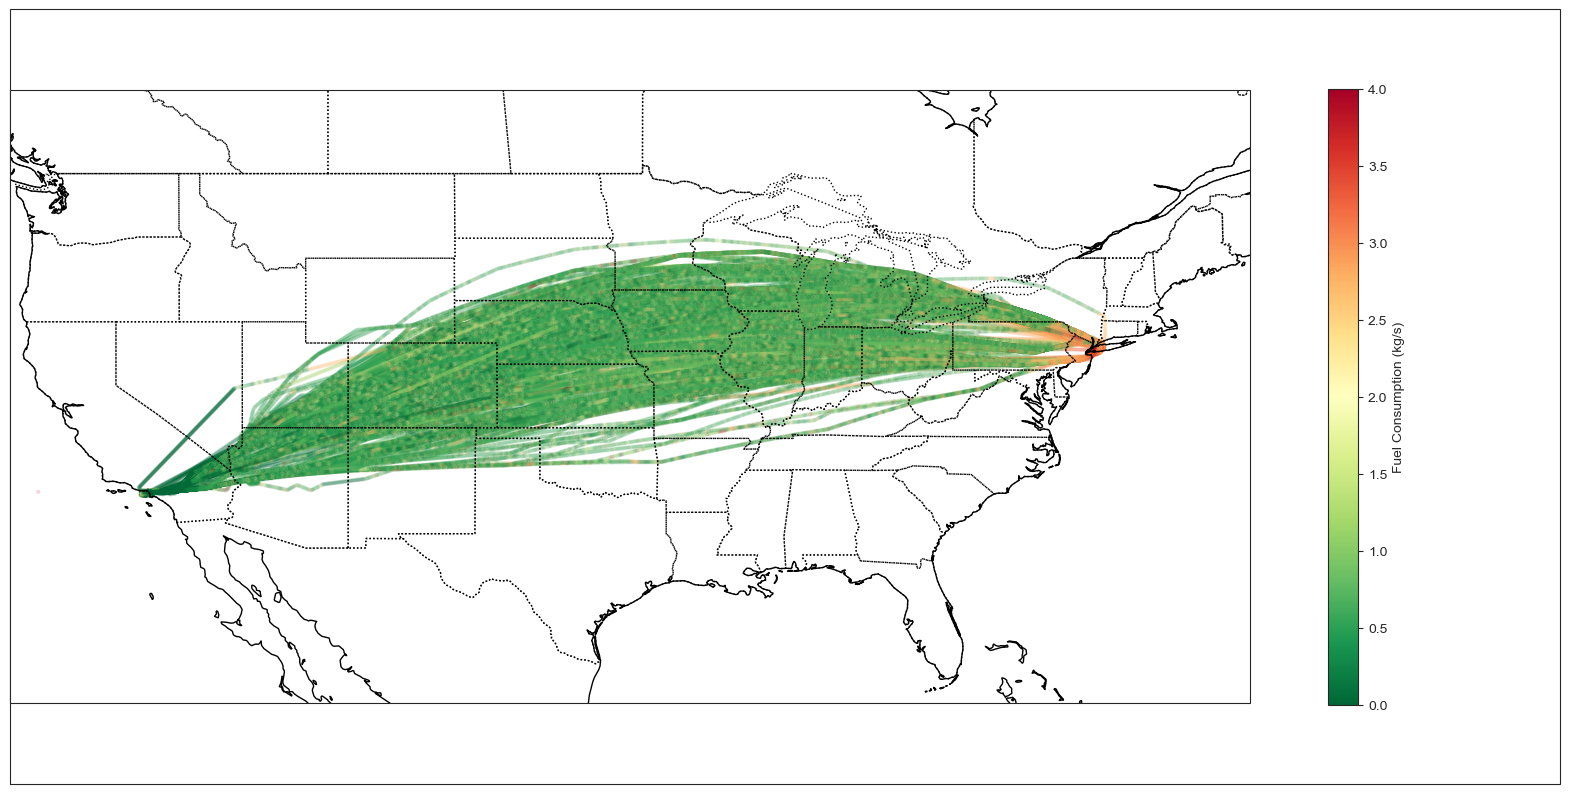

In [21]:
# Use a style
sns.set_style("white")

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=[20, 20])

# Create a GeoAxes in the PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and states
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.set_extent([-125, -66.5, 24, 49.5])

# Create a colormap
cmap = sns.color_palette("RdYlGn_r", as_cmap=True)
norm = mcolors.Normalize(vmin=0, vmax=4)

for flight in flights_w_fuel:
    ax.scatter(flight['lon'], flight['lat'], c= flight['fuelflow'], cmap=cmap, s=5, alpha=0.1)

sc = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sc, label='Fuel Consumption (kg/s)', shrink=0.4)


# Show the plot
plt.show()

## Histogram of fuel consumption data

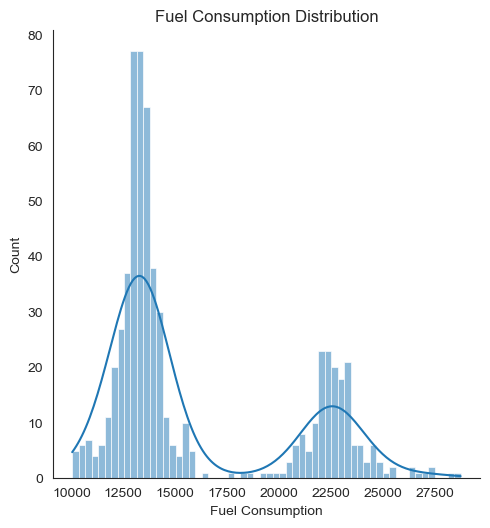

In [22]:
sns.displot(fuel_consumption, kde=True, bins=60)
plt.xlabel('Fuel Consumption')
plt.title('Fuel Consumption Distribution')
plt.show()